## 092260 - HW1
### Submitted by Tom Ron 305065658

In [55]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 5)})

from statsmodels.tsa.stattools import acf, pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

## Data loading and plotting

In [46]:
yield_data = pd.read_csv("data/YieldCurve.csv", parse_dates=['Date'])
moodys_data = pd.read_csv("data/BAA10Y.csv", parse_dates=['DATE']).rename(columns={"DATE":"Date"}).replace(".", np.nan)

Manually create date axis due to missing dates in both datasets

In [47]:
print("Yield date range: ({}, {})".format(yield_data['Date'].min().strftime("%Y-%m-%d"),
                                          yield_data['Date'].max().strftime("%Y-%m-%d")))
print("Moodys date range: ({}, {})".format(moodys_data['Date'].min().strftime("%Y-%m-%d"),
                                           moodys_data['Date'].max().strftime("%Y-%m-%d")))
min_date = min(yield_data['Date'].min(), moodys_data['Date'].min())
max_date = max(yield_data['Date'].max(), moodys_data['Date'].max())

dates_idx = pd.date_range(start=min_date, end=max_date, freq='B') # Buisness days, exclude weekends
dates = pd.DataFrame({'Date': dates_idx})

Yield date range: (1990-01-02, 2019-12-06)
Moodys date range: (1986-01-02, 2019-12-05)


In [48]:
dates

,Date
0,1986-01-02
1,1986-01-03
2,1986-01-06
3,1986-01-07
4,1986-01-08
...,...
8847,2019-12-02
8848,2019-12-03
8849,2019-12-04
8850,2019-12-05


In [49]:
yield_data_full = pd.merge(dates, yield_data, on='Date', how='left')
moodys_data_full = pd.merge(dates, moodys_data, on='Date', how='left')
data = pd.merge(yield_data_full, moodys_data_full, on='Date')

In [50]:
data

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,BAA10Y
0,1986-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.34
1,1986-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.30
2,1986-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.29
3,1986-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.35
4,1986-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8847,2019-12-02,1.60,1.58,1.60,1.62,1.60,1.61,1.63,1.65,1.77,1.83,2.15,2.28,2.11
8848,2019-12-03,1.56,1.54,1.57,1.57,1.57,1.53,1.54,1.54,1.65,1.72,2.03,2.17,2.11
8849,2019-12-04,1.59,1.54,1.55,1.56,1.56,1.58,1.58,1.60,1.71,1.77,2.08,2.22,2.11
8850,2019-12-05,1.52,1.56,1.54,1.55,1.56,1.58,1.60,1.62,1.73,1.80,2.11,2.24,2.09


In [51]:
cols = list(data.columns)
data[cols[1:]] = data[cols[1:]].apply(pd.to_numeric)
melted_data = pd.melt(data, ['Date'])

In [52]:
melted_data

,Date,variable,value
0,1986-01-02,1 Mo,NaN
1,1986-01-03,1 Mo,NaN
2,1986-01-06,1 Mo,NaN
3,1986-01-07,1 Mo,NaN
4,1986-01-08,1 Mo,NaN
...,...,...,...
115071,2019-12-02,BAA10Y,2.11
115072,2019-12-03,BAA10Y,2.11
115073,2019-12-04,BAA10Y,2.11
115074,2019-12-05,BAA10Y,2.09


### Plots

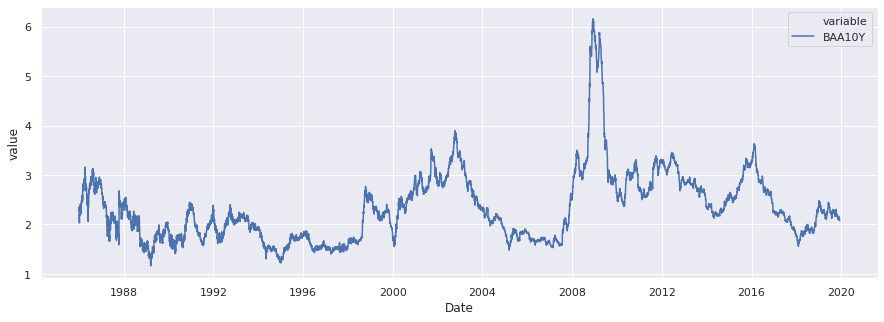

In [6]:
# Moody's
plot_data = melted_data[melted_data['variable'] == 'BAA10Y']
sns.lineplot(x='Date', y='value', hue='variable', data=plot_data)

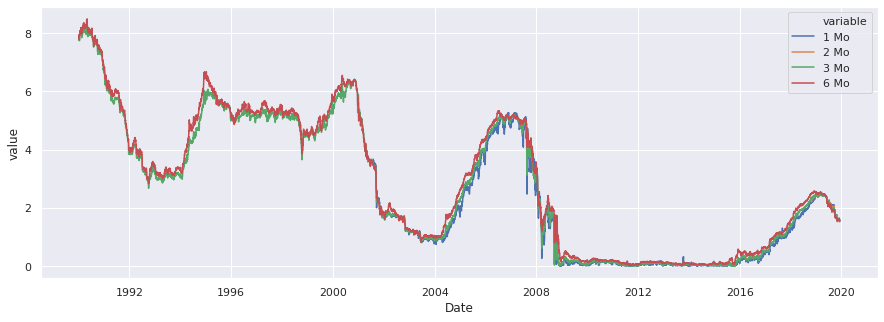

In [7]:
# Short term yields
plot_data = melted_data[melted_data['variable'].isin([x for x in cols if 'Mo' in x])]
sns.lineplot(x='Date', y='value', hue='variable', data=plot_data)

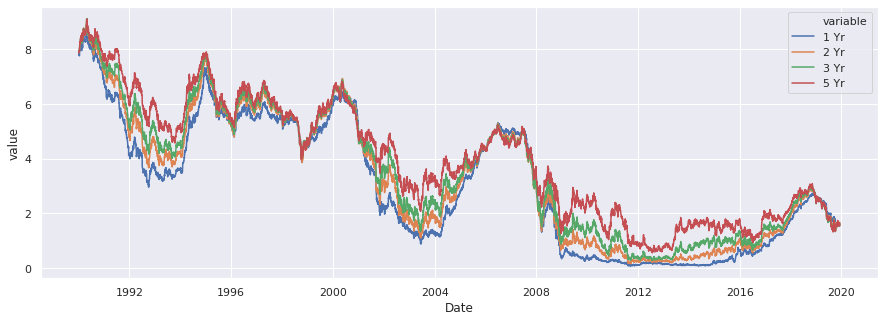

In [8]:
# Medium term yields
plot_data = melted_data[melted_data['variable'].isin(['1 Yr', '2 Yr', '3 Yr', '5 Yr'])]
sns.lineplot(x='Date', y='value', hue='variable', data=plot_data)

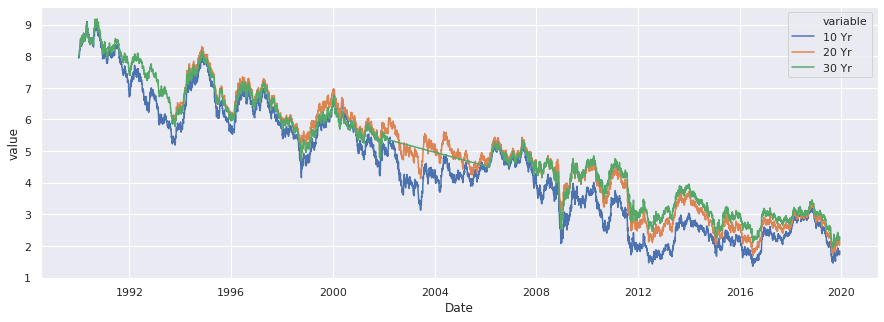

In [9]:
# Long term yields
plot_data = melted_data[melted_data['variable'].isin(['10 Yr', '20 Yr', '30 Yr'])]
sns.lineplot(x='Date', y='value', hue='variable', data=plot_data)

### Missing Data

In [56]:
data.groupby(pd.Grouper(key='Date', freq='1m')).count()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,BAA10Y
Date,,,,,,,,,,,,,
1986-01-31,0,0,0,0,0,0,0,0,0,0,0,0,21
1986-02-28,0,0,0,0,0,0,0,0,0,0,0,0,19
1986-03-31,0,0,0,0,0,0,0,0,0,0,0,0,20
1986-04-30,0,0,0,0,0,0,0,0,0,0,0,0,22
1986-05-31,0,0,0,0,0,0,0,0,0,0,0,0,21
1986-06-30,0,0,0,0,0,0,0,0,0,0,0,0,21
1986-07-31,0,0,0,0,0,0,0,0,0,0,0,0,22
1986-08-31,0,0,0,0,0,0,0,0,0,0,0,0,21
1986-09-30,0,0,0,0,0,0,0,0,0,0,0,0,21


## Data analysis

### Q.1 

In [61]:
# Filter train and test data
train_lb = '1990-01-01'
train_ub = '2015-12-31'
test_lb = '2016-01-01'
test_ub = '2016-12-31'

train_data = data[(data['Date'] >= train_lb) & (data['Date'] <= train_ub)]
m_train_data = pd.melt(train_data, ['Date'])
test_data = data[(data['Date'] >= test_lb) & (data['Date'] <= test_ub)]
m_test_data = pd.melt(test_data, ['Date'])

Before analyzing trend, seasonality, stationary etc., we will need to adaquetly model the time series. We shall use ACF plots for determining the apropriate ARIMA parameters for each series.
...Turns out that the time series data has a high level of missing data. Need to impute carefully.

In [57]:
a, b = acf(plot_data, nlags=lags, fft=True, missing='conservative', alpha=.05)

In [60]:
b

array([[ 1.        ,  1.        ],
       [ 0.97502702,  1.02261915],
       [ 0.95662155,  1.03898888],
       ...,
       [-0.43767863,  0.41158397],
       [-0.43804167,  0.41122139],
       [-0.43841284,  0.41085069]])

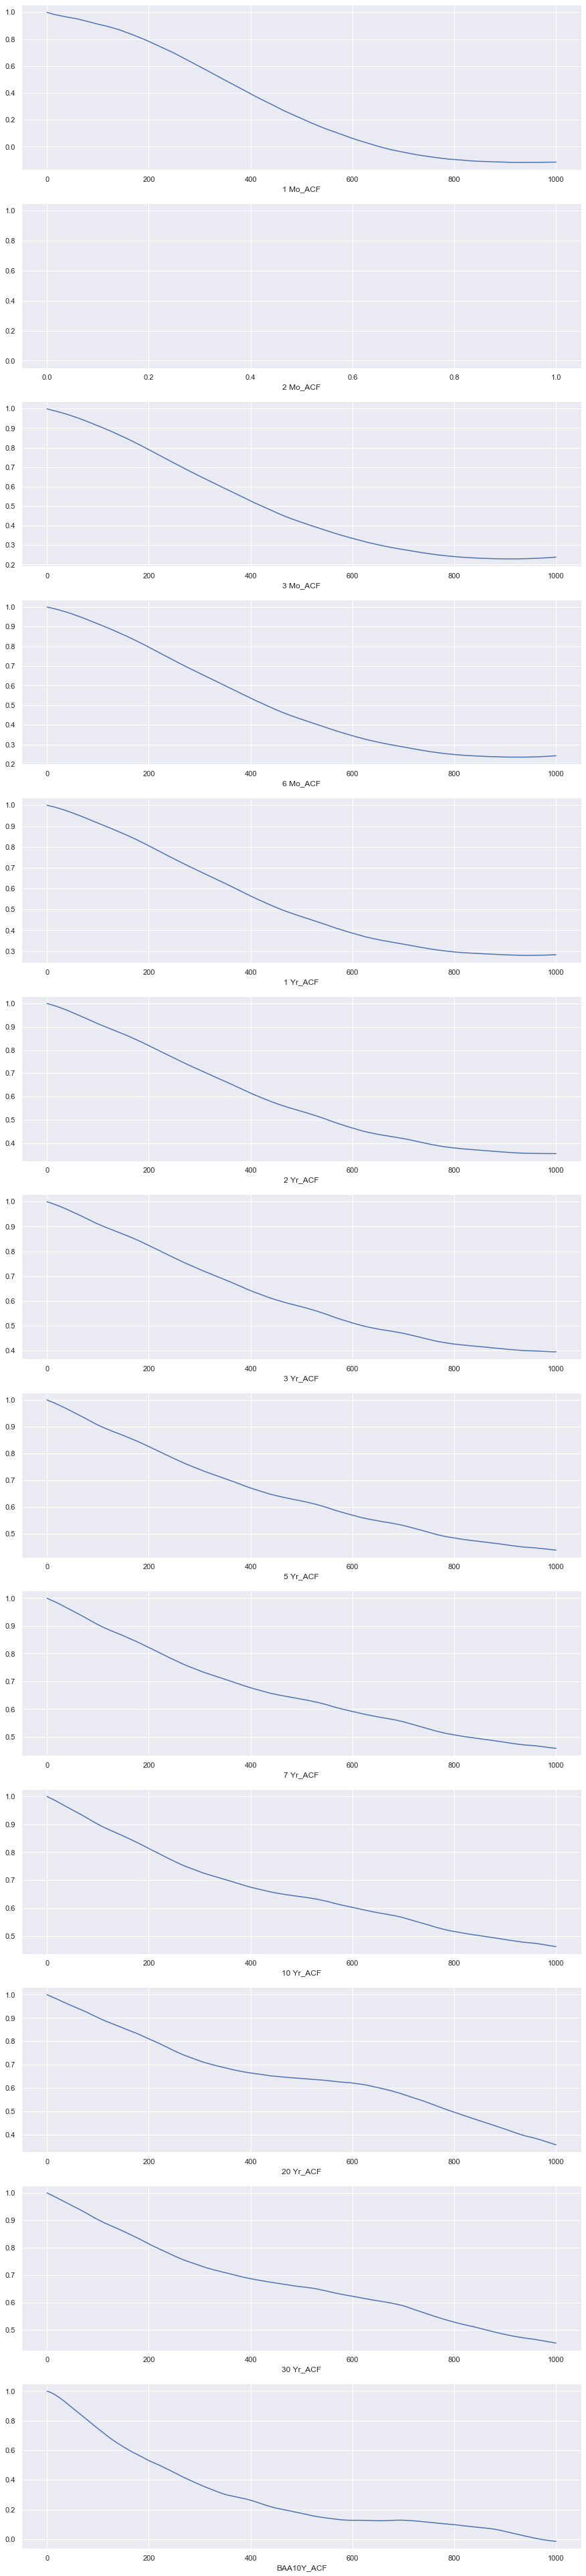

In [63]:
# We plot ACF for every series. We'll use FFT due to long
fig, axes = plt.subplots(len(cols[1:]), figsize=(15,70))
i = 0
nlgas = 10000
for col in cols[1:]:
    plot_data = m_train_data[m_train_data['variable'] == col]['value'].values
    
    axes[i].plot(acf(plot_data, nlags=lags, missing='conservative'))
    axes[i].set_xlabel('{}_ACF'.format(col))
    i += 1
    
#     axes[i+1].plot(pacf(plot_data, nlags=lags, missing='conservative'), label='{}_PACF'.format(col))
#     i += 1

In [47]:
m_train_data[m_train_data['variable'] == 'BAA10Y']['value'].value_counts(dropna=False)

NaN     279
1.67     85
1.70     83
1.68     80
1.71     75
       ... 
5.80      1
5.74      1
5.28      1
5.67      1
5.43      1
Name: value, Length: 370, dtype: int64

# To be continued...

### Q.2

We need to construct our data towards two classification tasks:

**Task 1 - Interest yield change classification**

$X_{yie}$: selected features

$y_{yie}$: Has the interest yield went up in the subsequent period - Yes (1) / No (0)

**Task 2 - Credit spread change classification**

$X_{cs}$: selected features

$y_{cs}$: Has the credit spread went up in the subsequent period - Yes (1) / No (0)

We will construct these datasets for (i) Daily, (ii) Monthly and (iii) Yearly time frames.

#### Q2.1
**Daily rates**

We will construct T-days indapendant sequences of the time series and calculate $y$ as: 

$y=0$ if $I[(R_\text{yield at t=T+1} - R_\text{yield at t=T}) \le 0]$

$y=1$ if $I[(R_\text{yield at t=T+1} - R_\text{yield at t=T}) > 0]$ 

We will address T is a hyperparameter in model evaluation.

In [57]:
data

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,BAA10Y
0,1986-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.34
1,1986-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.30
2,1986-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.29
3,1986-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.35
4,1986-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8847,2019-12-02,1.60,1.58,1.60,1.62,1.60,1.61,1.63,1.65,1.77,1.83,2.15,2.28,2.11
8848,2019-12-03,1.56,1.54,1.57,1.57,1.57,1.53,1.54,1.54,1.65,1.72,2.03,2.17,2.11
8849,2019-12-04,1.59,1.54,1.55,1.56,1.56,1.58,1.58,1.60,1.71,1.77,2.08,2.22,2.11
8850,2019-12-05,1.52,1.56,1.54,1.55,1.56,1.58,1.60,1.62,1.73,1.80,2.11,2.24,2.09
